# MACHINE LEARNING EXPLAINABILITY

### The Model

In [1]:
import pandas as pd
import numpy as np
import os
from house_price_predictor.data_engineering.loaddata_fromdb import *

# Import Data to Dataframe
melb_house_prices = get_df('melb_data')

# Extract Target column from Data
X = melb_house_prices.drop('price', axis=1)
y = melb_house_prices.price

# Preprocessing

# Convert date to datetime
X['date'] = pd.to_datetime(X['date'], format='%d/%m/%Y')
X['year_sold'] = X['date'].dt.year

# Convert landsize to landsize_log
X['landsize_log'] = pd.Series(np.log(X['landsize']+1))

# create dictionary of suburb with its property counts and region
suburb_df= X.groupby("suburb")[["propertycount", "regionname"]].agg({'propertycount':'mean', 'regionname':'first'})
# create a series with each uniqiue suburb as index and its corresponding property count and region. Both mean() and size() can be used as each suburb has a fixed propertycount
suburb_dict = suburb_df.to_dict(orient='index') # use the series to create a dictonary

# Remove unnecessary features
features_to_remove = ['suburb', 'address', 'method', 'date', 
                        'postcode', 'bedroom2', 'car', 'landsize',
                        'buildingarea', 'yearbuilt', 'councilarea']
X.drop(features_to_remove, axis=1, inplace=True)

# Change seller names to lowercase
X['sellerg']=X['sellerg'].str.lower()

# Target type, regionname and SellerG features
from category_encoders import TargetEncoder
TargetEncodeCols = ['type', 'regionname', 'sellerg']
te = TargetEncoder(cols=TargetEncodeCols)
X = te.fit_transform(X, y)

X[TargetEncodeCols] /= 100000

# Train-Tes split
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1)


# Train Random Forest Regressor model with n_estimators=450, max_features=4
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=450, max_features=4, random_state=1)
model.fit(train_X, train_y)

/Users/georgethomas/Documents/ML/APR_2023/PROJECTS/HOUSE-PRICE-PREDICTOR/house_price_predictor/data_engineering/
data_engineering


RandomForestRegressor(max_features=4, n_estimators=450, random_state=1)

### Permutation Importance

In [38]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(test_X, test_y)
weights_html = eli5.show_weights(perm, feature_names = test_X.columns.tolist())
weights_html

Weight,Feature
0.1829 ± 0.0189,type
0.1663 ± 0.0213,rooms
0.1629 ± 0.0183,regionname
0.1626 ± 0.0051,distance
0.1506 ± 0.0189,landsize_log
0.0942 ± 0.0049,lattitude
0.0862 ± 0.0043,longtitude
0.0638 ± 0.0069,bathroom
0.0585 ± 0.0090,sellerg
0.0133 ± 0.0026,propertycount


In [40]:
path = os.getcwd()
parent_dir = os.path.dirname(path)
path = parent_dir+'/resources/'
path

'/Users/georgethomas/Documents/ML/APR_2023/PROJECTS/HOUSE-PRICE-PREDICTOR/house_price_predictor/resources/'

In [41]:
# Export the Permuation Importance table as an HTML file.
from IPython.display import HTML
html_str = HTML(weights_html.data).data
with open(path+'weights.html', 'w') as f:
    f.write(html_str)

### Partial Dependence Plots

In [20]:
test_X.columns

Index(['rooms', 'type', 'sellerg', 'distance', 'bathroom', 'lattitude',
       'longtitude', 'regionname', 'propertycount', 'year_sold',
       'landsize_log'],
      dtype='object')

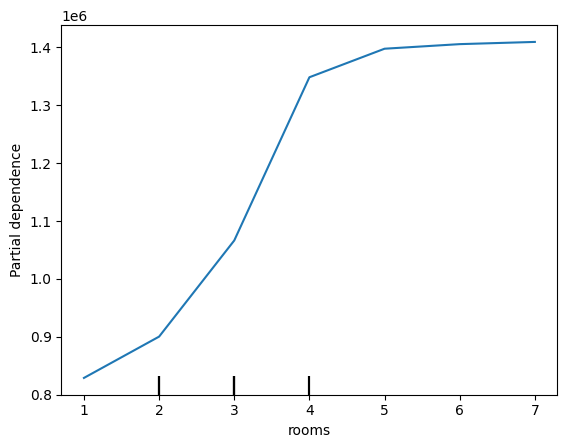

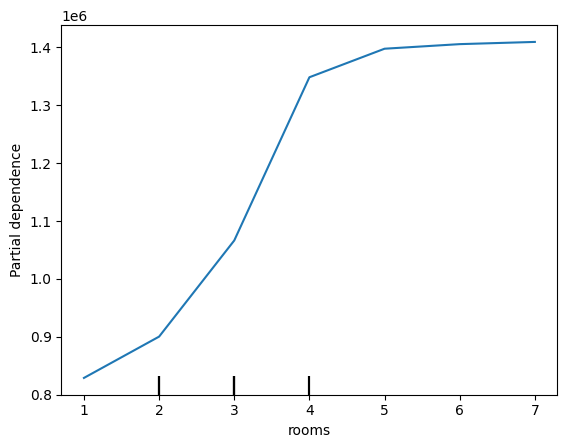

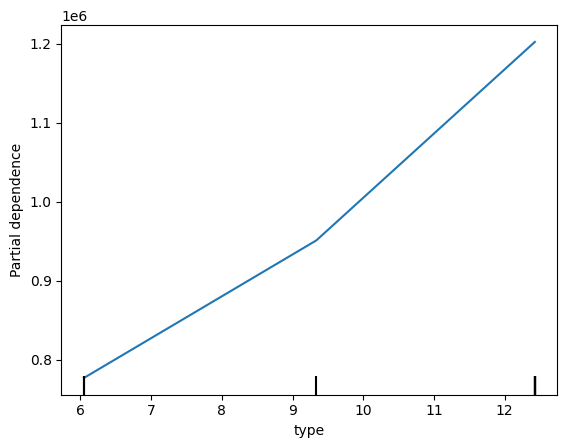

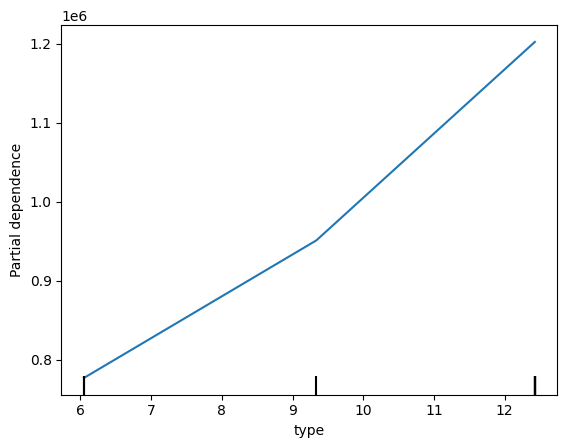

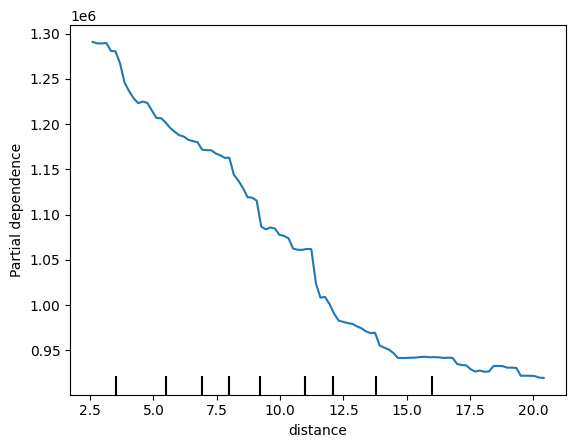

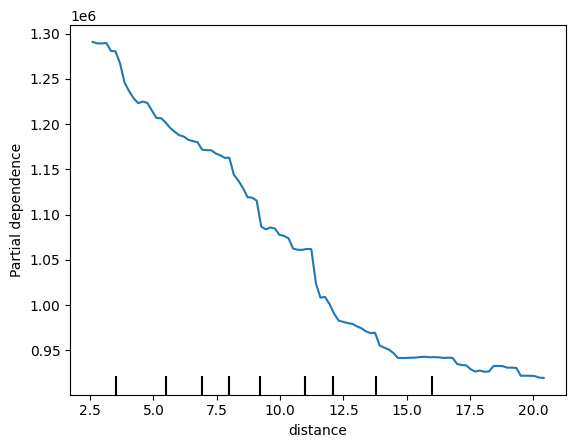

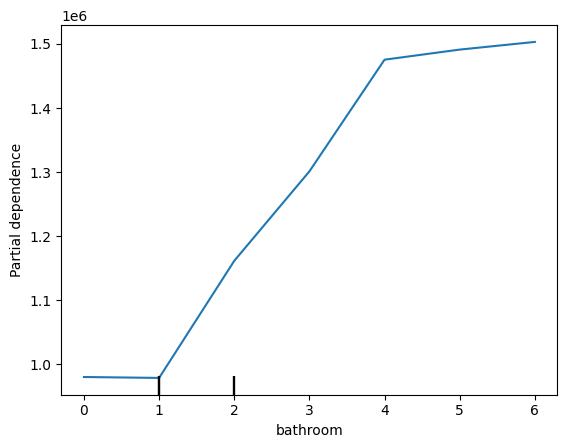

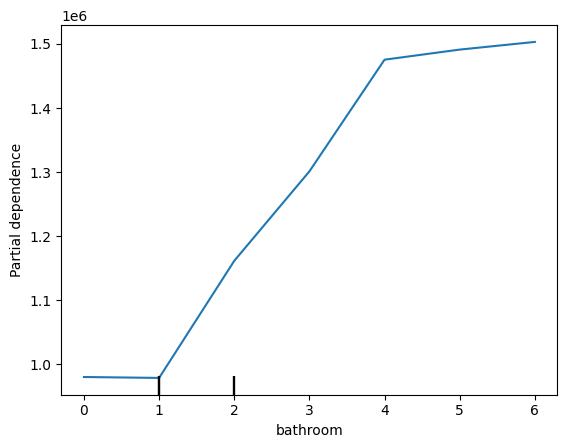

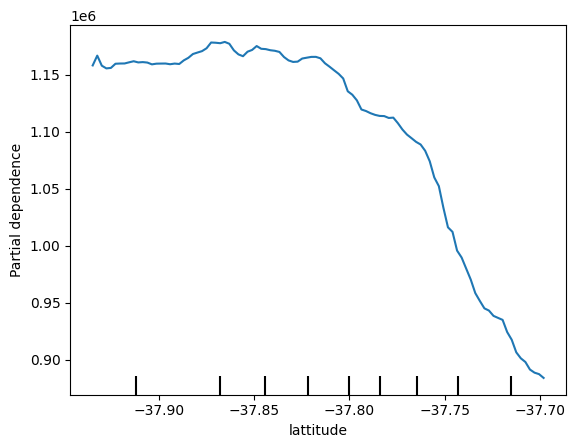

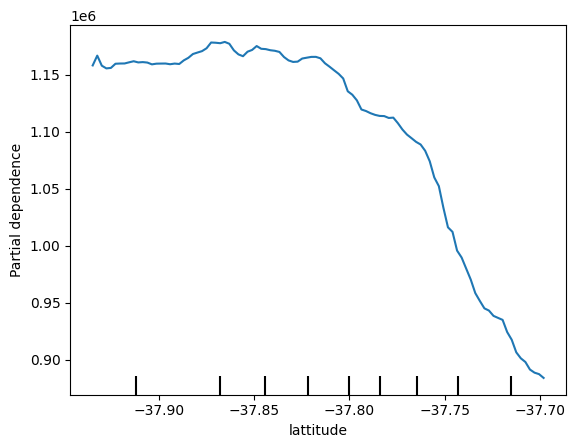

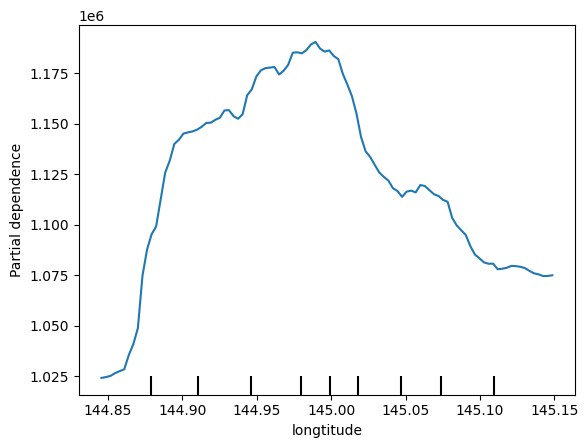

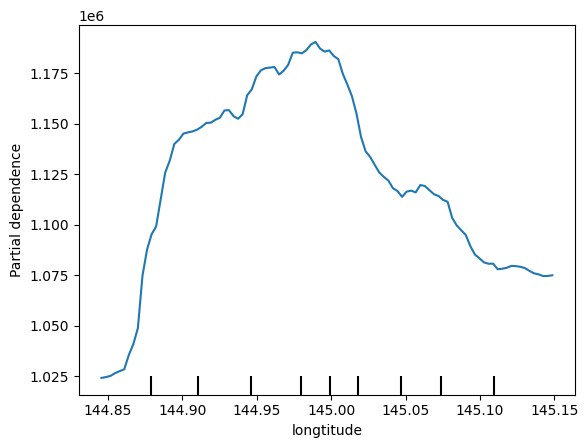

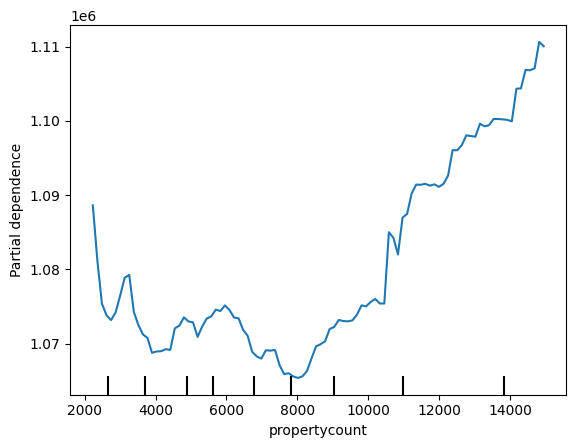

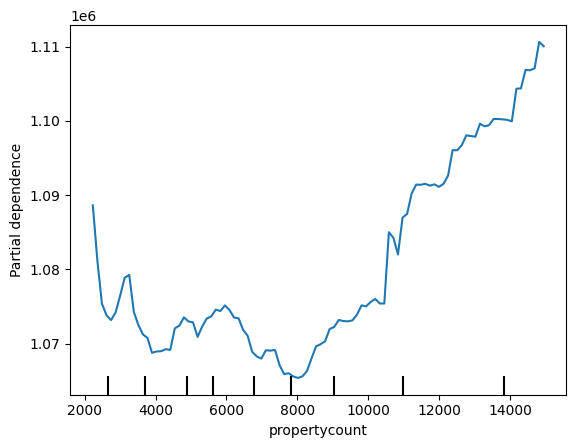

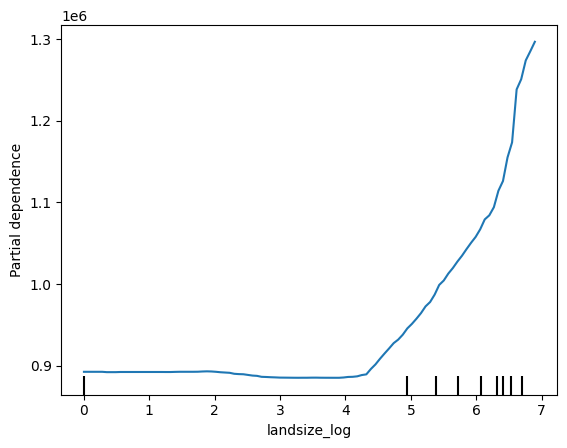

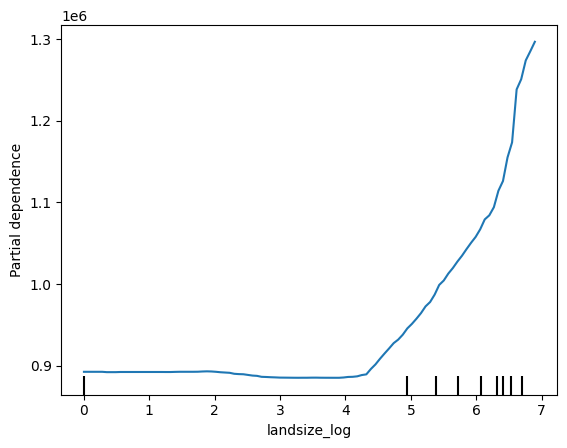

In [37]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

i=0
for feature in ['rooms', 'type', 'distance', 'bathroom', 'lattitude',
       'longtitude', 'propertycount', 'landsize_log']:
    display = PartialDependenceDisplay.from_estimator(model, test_X, [feature])
    fig, ax = plt.subplots()
    display.plot(ax=ax)
    i+=1
    fig.savefig(f'explainability_images/partial_dependence_{i}.png')


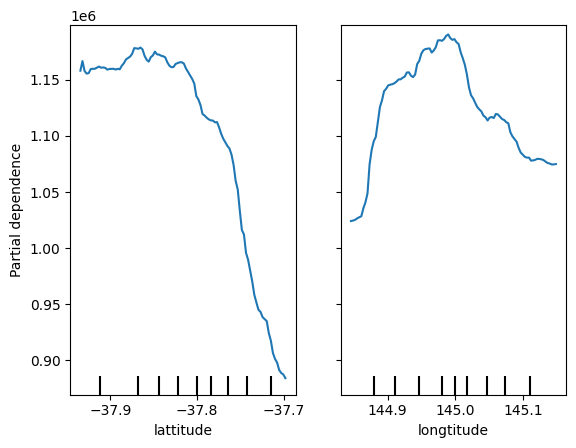

In [42]:

PartialDependenceDisplay.from_estimator(model, test_X, ['lattitude', 'longtitude'])

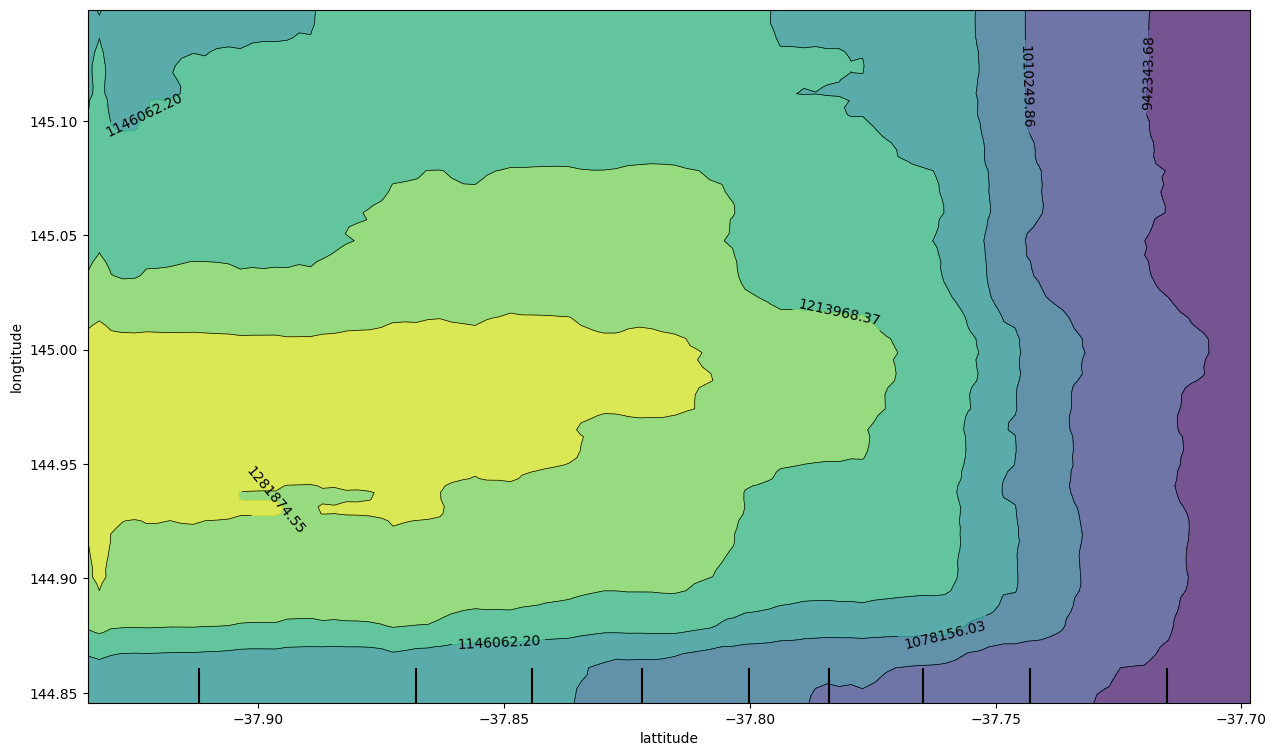

In [43]:
fig, ax = plt.subplots(figsize = (15, 9))
features = [('lattitude', 'longtitude')]
PartialDependenceDisplay.from_estimator(model, test_X, features, ax = ax)

### SHAP values

In [44]:
data_for_prediction = test_X.iloc[[10]]
model.predict(data_for_prediction)

array([1321846.44444444])

In [45]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)

In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [47]:
row = 20
data_for_prediction = test_X.iloc[[row]]
model.predict(data_for_prediction)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

In [48]:
shap_values

array([[ -14984.28579316,   82997.87739142,  -69858.49812794,
         -58071.01860924,  -52362.79491253, -151734.46362431,
          66821.98982706, -112062.29607802,   14657.29398631,
          20725.5253701 ,   -2766.87916726]])

In [49]:
t1 = (shap_values/1000).astype(int).tolist()
df1 = pd.DataFrame(t1, columns = test_X.columns)
row = df1.iloc[0]
row[row!=0]

rooms            -14
type              82
sellerg          -69
distance         -58
bathroom         -52
lattitude       -151
longtitude        66
regionname      -112
propertycount     14
year_sold         20
landsize_log      -2
Name: 0, dtype: int64

In [50]:
main_factors = row[row!=0]

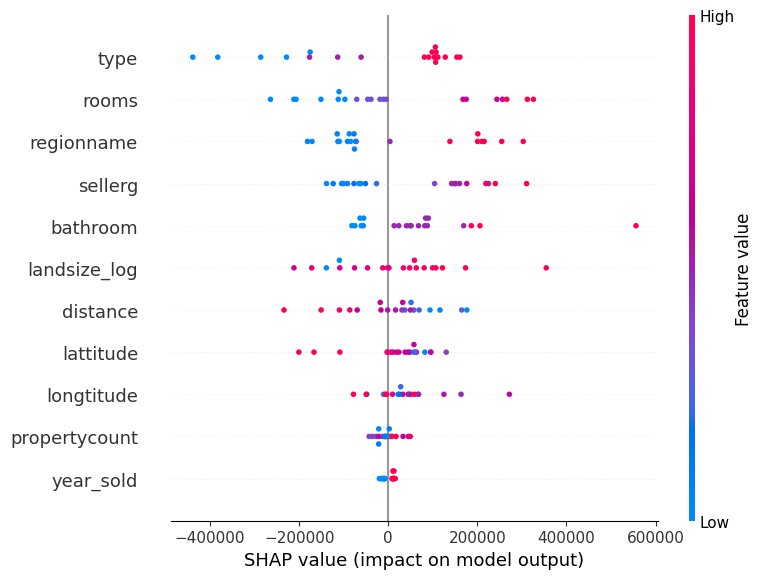

In [52]:
smal_X = test_X.iloc[:20]
shap_values_all = explainer.shap_values(smal_X)
shap.summary_plot(shap_values_all, smal_X)

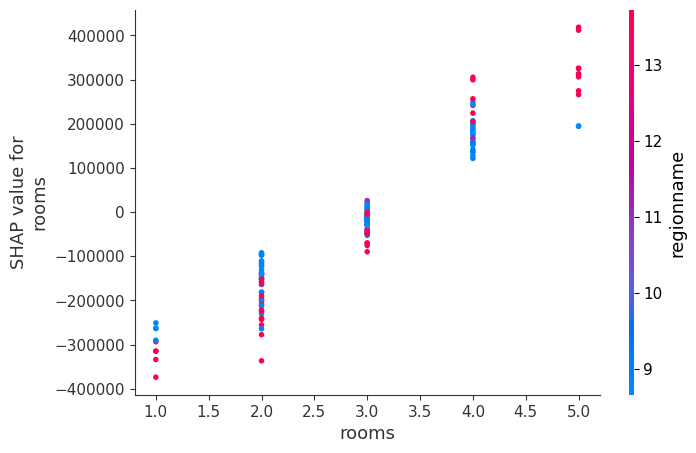

In [53]:
shap_values2 = explainer.shap_values(test_X.iloc[:150])
shap.dependence_plot("rooms", shap_values2, test_X[:150])

In [54]:
row = 20
data_for_prediction = test_X.iloc[[row]]
model.predict(data_for_prediction)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)


In [55]:
max_digits = len(
    str(
        abs(shap_values).astype(int).max()
        )
    )
div = 10**(max_digits-2)

feat_weights = pd.DataFrame(
                (shap_values/div).astype(int).tolist(), 
                columns=X.columns)
feat_weights

,rooms,type,sellerg,distance,bathroom,lattitude,longtitude,regionname,propertycount,year_sold,landsize_log
0,-1,8,-6,-5,-5,-15,6,-11,1,2,0


<Axes: >

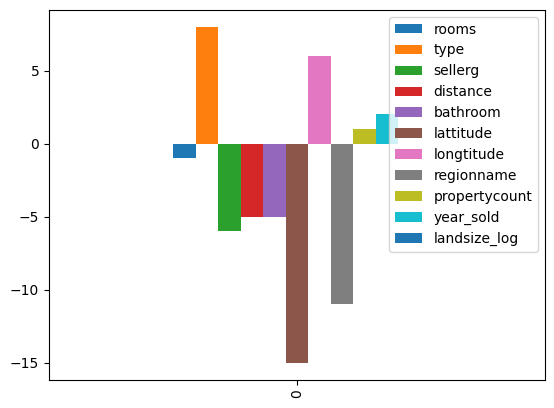

In [56]:
feat_weights.plot(kind='bar')

In [57]:
import seaborn as sns

In [58]:
feat_weights = feat_weights.loc[:, (feat_weights!=0).any(axis=0)]
feat_weights

,rooms,type,sellerg,distance,bathroom,lattitude,longtitude,regionname,propertycount,year_sold
0,-1,8,-6,-5,-5,-15,6,-11,1,2


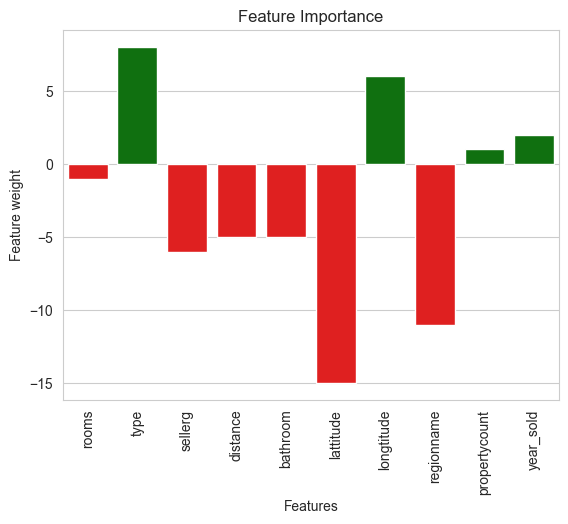

In [60]:
sns.set_style("whitegrid")
ax = sns.barplot(data=feat_weights, palette=['g' if x >= 0 else 'r' for x in feat_weights.values[0]])
ax.set_title("Feature Importance")
ax.set_xlabel("Features")
ax.set_ylabel("Feature weight")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()
